In [1]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, getcwd, system, getenv
from astropy.io import fits
from time import perf_counter
import urllib.request

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import matplotlib.gridspec as gridspec

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
# from deconv import cube_deconv
# from ppxf_wrap import ppxf_wrap

# import warnings

# if True:
#     print('Set warnings.filterwarnings as "ignore"')
#     print('Warning Message will not be printed')
#     warnings.filterwarnings("ignore")

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import constants
import pandas as pd

# import plotly.express as px
from astroquery.mast import Observations


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.nddata.utils import Cutout2D

from astropy.wcs import WCS
import astropy

In [2]:
def set_rcparams_prop(amp=1, fs=22, tickamp=None):
#     fs=18
    if tickamp==None:
        tickamp=amp
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*tickamp
    tmns=tmjs/3.5*2
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [3]:

obs_table = Observations.query_region("322.49324 12.16683")

In [4]:
objnames=['M 82','NGC 7090','NGC 4736','NGC 5055','NGC 2403',
          'NGC 5194','M 101','NGC 3031','NGC 6744','NGC 253',
          'NGC 3079','NGC 5866','NGC 4151','NGC 1313',
          'NGC 4631','NGC 891'
         ]

obs_tables=[]
for objname in objnames:
    print(objname)
    obs_tables.append(Observations.query_criteria(obs_collection='FUSE',objectname=objname, radius=".5 deg"))
# objname='NGC4631'
# obs_table = Observations.query_criteria(filters=["FUV","GALEX"],objectname=objname, radius=".02 deg")
# obs_table = Observations.query_criteria(filt=["FUSE"],objectname=objname, radius=".5 deg")
obs_table = Observations.query_criteria(obs_collection='FUSE',objectname="NGC4631", radius=".5 deg")


M 82
NGC 7090
NGC 4736
NGC 5055
NGC 2403
NGC 5194
M 101
NGC 3031
NGC 6744
NGC 253
NGC 3079
NGC 5866
NGC 4151
NGC 1313
NGC 4631
NGC 891


In [5]:

# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check

print(obs_tables[0]['target_name'])
obs_tables[0].colnames
obs_tables[4]

exptimes=obs_tables[4]['t_exptime']
print(exptimes)
cond=exptimes>5000
# print(obs_tables[4][cond])
fexptimes=obs_tables[4][cond]['t_exptime']
# cond
print(obs_tables[4][0])
down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp'
pl=Observations.get_product_list(obs_tables[4])
# np.sum(pl['productType']=="SCIENCE")
# pl.colnames
urls=pl['dataURI']
rr=[x.find('00000all4ttag') for x in urls]

target_name
-----------
      M82-A
      M82-B
      M82-C
      M82-D
t_exptime
---------
  21890.0
  17172.0
  18372.0
  30420.0
   1394.0
  16380.0
   6692.0
dataproduct_type calib_level obs_collection    obs_id    target_name         s_ra          s_dec       t_min          t_max     t_exptime wavelength_region filters     em_min        em_max     target_classification                  obs_title                   t_obs_release instrument_name proposal_pi proposal_id proposal_type project sequence_number provenance_name                      s_region                                                          jpegURL                                                                         dataURL                                     dataRights mtFlag srcDen intentType obsid  objID  objID1      distance     
---------------- ----------- -------------- ----------- ------------- ------------------ --------- -------------- ------------- --------- ----------------- ------- ------------- -----

In [6]:
pl['obs_id']
pl.colnames

['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [7]:
urls

mast:FUSE/url/pub/fuse/data/f9180202/f9180202001fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202002fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202003fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202004fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202005fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202006fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f9180202701fesbfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020011attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020011bttagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020012attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/f9180202/f91802020012bttagfraw.fit.gz


In [8]:
aa=np.array(rr)
print(np.sum(aa>0))
obs_tables[4]

urls[aa>0]
# pl
pl['productFilename']

fnames=[]


#download files
down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
for i in range(len(obs_tables)):
# for i in [6]:
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
#     rr=[x.find('00000all3ttag') for x in urls]
#     dpl=pl[np.array(rr)>0]
#     print(urls)
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(obs_tables[i]['target_name'])
#     print(manifest)
    
#     exptimes=obs_tables[4]['t_exptime']
# #     print(exptimes)
# #     cond=exptimes>5000
#     # print(obs_tables[4][cond])
#     fexptimes=obs_tables[4][cond]['t_exptime']
    

7
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c1310101/c1310101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310101/c1310101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010021attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010021bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010022attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c1310101/c13101010022bttagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/c1310401/c13104010031blif4ttagfcal.fit.gz
mast:FUSE/url/pub/

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c1310101000\c131010100000all4ttagfcal.fit.gz with expected size 613259. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c1310201000\c131020100000all4ttagfcal.fit.gz with expected size 615430. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c1310301000\c131030100000all4ttagfcal.fit.gz with expected size 617437. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c1310401000\c131040100000all4ttagfcal.fit.gz with expected size 616795. [astroquery.query]
target_name
-----------
      M82-A
      M82-B
      M82-C
      M82-D
                                                     Local Path                                                      ...
-----------------------------------------------------------

                               dataURI                               
---------------------------------------------------------------------
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001001fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001002fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001003fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001004fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001005fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001006fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001008fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001010fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001012fesafraw.fit.gz
 mast:FUSE/url/missions/fuse/data/b1061001/b1061001701fesafraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/b1061101/b10611010072blif4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1061001000\b106100100000all4ttagfcal.fit.gz with expected size 606966. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1061101000\b106110100000all4ttagfcal.fit.gz with expected size 608845. [astroquery.query]
target_name 
------------
NGC4736-POS2
NGC4736-POS1
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1061001000\b106100100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1061101000\b106110100000all4ttagfcal.fit.gz ...
                               dataURI                                
-------------------

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060901000\b106090100000all4ttagfcal.fit.gz with expected size 595045. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\e0950101000\e095010100000all4ttagfcal.fit.gz with expected size 617105. [astroquery.query]
target_name 
------------
     NGC5055
NGC5055-POS1
NGC5055-POS2
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060801000\b106080100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060901000\b106090100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\e0950

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\f9180302000\f918030200000all4ttagfcal.fit.gz with expected size 614533. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\f9180402000\f918040200000all4ttagfcal.fit.gz with expected size 611605. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\f9180501000\f918050100000all4ttagfcal.fit.gz with expected size 612288. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\f9180601000\f918060100000all4ttagfcal.fit.gz with expected size 591262. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\f9180602000\f918060200000all4ttagfcal.fit.gz with expected size 611953. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Resear

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060101000\b106010100000all4ttagfcal.fit.gz with expected size 394345. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060201000\b106020100000all4ttagfcal.fit.gz with expected size 606920. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060301000\b106030100000all4ttagfcal.fit.gz with expected size 603788. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060401000\b106040100000all4ttagfcal.fit.gz with expected size 393155. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1060501000\b106050100000all4ttagfcal.fit.gz with expected size 608767. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Resear

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\h0760202000\h076020200000all4ttagfcal.fit.gz with expected size 400300. [astroquery.query]
target_name
-----------
    NGC6744
    NGC6744
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\h0760201000\h076020100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\h0760202000\h076020200000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c1310501/c1310501002fesafraw.fit.gz
 

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101007fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101009fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101011fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101013fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101014fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d0390101/d0390101015fesafraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/p2072901/p20729010021asic4ttagfcal.fit.gz
mast:FUSE/url/pub/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p2072901000\p207290100000all4ttagfcal.fit.gz with expected size 605344. [astroquery.query]
target_name
-----------
    NGC3079
    NGC3079
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\d0390101000\d039010100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p2072901000\p207290100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/f9191601/f9191601001fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/f9191601/f9191601002fesbfraw.fit.gz
 

                                 dataURI                                  
--------------------------------------------------------------------------
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101001fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101002fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101003fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101005fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101006fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101007fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101008fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101009fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101010fesafraw.fit.gz
      mast:FUSE/url/missions/fuse/data/c0920101/c0920101011fesafraw.fit.gz
                                                                       ...
mast:FUSE/url/missions/fu

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1110505000\p111050500000all4ttagfcal.fit.gz with expected size 613784. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p2110201000\p211020100000all4ttagfcal.fit.gz with expected size 614799. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p2110202000\p211020200000all4ttagfcal.fit.gz with expected size 608929. [astroquery.query]
target_name
-----------
    NGC4151
    NGC4151
    NGC4151
    NGC4151
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0920101000\c092010100000all4ttagfcal.fit.gz ...
C:/U

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\d9110401000\d911040100000all4ttagfcal.fit.gz with expected size 619826. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\u1063201000\u106320100000all4ttagfcal.fit.gz with expected size 591970. [astroquery.query]
target_name
-----------
    NGC1313
 Q0321-6657
 Q0321-6657
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\d9110301000\d911030100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\d9110401000\d911040100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\u106320100

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0570201000\c057020100000all4ttagfcal.fit.gz with expected size 606739. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0570202000\c057020200000all4ttagfcal.fit.gz with expected size 617921. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0570301000\c057030100000all4ttagfcal.fit.gz with expected size 608883. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\c0570401000\c057040100000all4ttagfcal.fit.gz with expected size 602786. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\p1340101000\p134010100000all4ttagfcal.fit.gz with expected size 613219. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Resear

INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1140201000\b114020100000all4ttagfcal.fit.gz with expected size 611946. [astroquery.query]
INFO: Found cached file C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1140301000\b114030100000all4ttagfcal.fit.gz with expected size 605639. [astroquery.query]
target_name
-----------
   NGC891-1
   NGC891-2
   NGC891-3
                                                     Local Path                                                      ...
-------------------------------------------------------------------------------------------------------------------- ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1140101000\b114010100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b1140201000\b114020100000all4ttagfcal.fit.gz ...
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/mastDownload\FUSE\b114030100

In [9]:
down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
# for i in range(len(obs_tables)):

df=pd.DataFrame()

# for i in range(1):
for i in range(len(obs_tables)):
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)
        
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)

# hdr        
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(manifest)

LWRS
LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
LWRS
LWRS
LWRS
MDRS
MDRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
MDRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipyker

LWRS
LWRS
LWRS


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\3777488710.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(sri, ignore_index=True)


In [10]:
# ndf.loc[0,'ra']
df.columns

Index(['objname', 'targname', 'ra', 'dec', 'pa', 'aperture', 'programid',
       'exptime', 'obsmode', 'fdir'],
      dtype='object')

In [11]:
# ndf[ndf['objname']=='M 101']
# ndf['objname']

In [12]:
tcut=5000
tcut=2000
ndf=df[df['exptime']>tcut]

df2=pd.DataFrame()


for i in range(len(objnames)):
    print(objnames[i])
    adf=ndf[ndf['objname']==objnames[i]]
    adf.index=np.arange(len(adf))
    sri=pd.Series({
        'objname':objnames[i],
        'ra':adf.loc[0,'ra'],
        'dec':adf.loc[0,'dec'],
        'npt':len(adf),
        'maxexp':np.max(adf.loc[:,'exptime'].values),
        'meanexp':np.mean(adf.loc[:,'exptime'].values),
    })
    df2=df2.append(sri, ignore_index=True)
df2


# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check


M 82
NGC 7090
NGC 4736
NGC 5055
NGC 2403
NGC 5194
M 101
NGC 3031
NGC 6744
NGC 253
NGC 3079
NGC 5866
NGC 4151
NGC 1313
NGC 4631
NGC 891


C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1836014309.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1836014309.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1836014309.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1836014309.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2=df2.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Tem

,objname,ra,dec,npt,maxexp,meanexp
0,M 82,148.987917,69.663750,4,11049.0,9401.750000
1,NGC 7090,324.104167,-54.568056,1,21459.0,21459.000000
2,NGC 4736,192.732083,41.140000,2,19038.0,14880.500000
3,NGC 5055,198.965833,42.056667,3,22997.0,12778.333333
4,NGC 2403,114.083625,65.618583,6,30420.0,18487.666667
5,NGC 5194,202.468125,47.195500,8,41784.0,17893.125000
6,M 101,210.922083,54.318056,7,33702.0,13514.857143
7,NGC 3031,148.679375,69.060694,8,24291.0,13137.750000
8,NGC 6744,287.442083,-63.857500,2,10895.0,10893.500000
9,NGC 253,11.896667,-25.295917,1,6216.0,6216.000000


In [13]:
def fstr(x):
    return x

def ff6(x):
    return '%.6f' % x


def ff4(x):
    return '%.4f' % x

def ff1(x):
    return '%.1f' % x

def ff2(x):
    return '%.2f' % x

def fint(x):
    return '%i' % x

def detection_check(x):
    if x>3:
        return 'Y'
    else:
        return 'N'

    
def rec_rotate(cx, cy, wx, wy, ang_deg): #angle: clocowise rot from 12h
    ang_rad=np.radians(ang_deg)
    wd=(wx**2+wy**2)**0.5
    ang_diagonal=np.arctan(wy/wx)
    ang_new=ang_diagonal+ang_rad
    rx=cx-wd/2*np.cos(ang_new)
    ry=cy-wd/2*np.sin(ang_new)
    return rx, ry
    
df2['randec']=df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['totalexp']=df2['meanexp']*df2['npt']

# coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.hourangle, u.deg))
coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.deg, u.deg))
df2['l']=coords.galactic.l.degree
df2['b']=coords.galactic.b.degree
df2['rvel']=[269,850,308,500,133,465,241,-39,841,259,1127,757,976,470,610,528]

df2['lnb']=df2['l'].apply(ff4)+', '+df2['b'].apply(ff4)

df2['owave']=1031.9*(1+df2['rvel']/299790)

# fmts=[fstr, ff4, ff4, fint, fint, fint]
# fmts=[fstr, ff4, ff4, fint, fint, fint,ff1]
fmts=[fstr, fstr, fint, fint, fint,ff1]
# fmts=[fstr, fstr, fint, fint, fint, fint]
# ridx1=[8,9,3,4,5,6,7,0,1,2]
latex_text=df2.to_latex(index=False, header=False,
                        formatters=fmts,
#              columns=['objname','ra','dec','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp','owave'])
             columns=['objname','lnb','npt','maxexp','totalexp','owave'])
#              columns=['objname','ra','dec','npt','maxexp','meanexp'])
print(latex_text)

print('\hline')
print(' & & & '+fint(np.sum(df2['npt']))+' & &  '+fint(np.sum(df2['npt']*df2['meanexp'])))

# df2.to_csv('adap_2022_targets.csv')

C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1680400279.py:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_text=df2.to_latex(index=False, header=False,


\begin{tabular}{llrrrr}
\toprule
    M 82 &  141.4213, 40.5818 & 4 & 11049 &  37607 & 1032.8 \\
NGC 7090 & 341.2857, -45.3731 & 1 & 21459 &  21459 & 1034.8 \\
NGC 4736 &  123.3282, 75.9879 & 2 & 19038 &  29761 & 1033.0 \\
NGC 5055 &  106.0059, 74.2593 & 3 & 22997 &  38335 & 1033.6 \\
NGC 2403 &  150.5486, 29.1325 & 6 & 30420 & 110926 & 1032.4 \\
NGC 5194 &  104.8543, 68.5609 & 8 & 41784 & 143145 & 1033.5 \\
   M 101 &  101.8876, 59.7590 & 7 & 33702 &  94604 & 1032.7 \\
NGC 3031 &  142.1535, 40.8416 & 8 & 24291 & 105102 & 1031.8 \\
NGC 6744 & 332.2241, -26.1465 & 2 & 10895 &  21787 & 1034.8 \\
 NGC 253 &  97.4776, -87.9743 & 1 &  6216 &   6216 & 1032.8 \\
NGC 3079 &  157.8074, 48.3618 & 2 & 58902 &  65167 & 1035.8 \\
NGC 5866 &   92.0342, 52.4892 & 1 &  2616 &   2616 & 1034.5 \\
NGC 4151 &  155.0773, 75.0632 & 4 & 48935 &  90054 & 1035.3 \\
NGC 1313 & 283.3587, -44.6436 & 3 & 15801 &  37630 & 1033.5 \\
NGC 4631 &  142.6550, 84.1916 & 7 & 27762 & 121539 & 1034.0 \\
 NGC 891 & 140.3686, -

In [14]:
np.min(df2['totalexp']),np.max(df2['totalexp'])
df2

,objname,ra,dec,npt,maxexp,meanexp,randec,totalexp,l,b,rvel,lnb,owave
0,M 82,148.987917,69.663750,4,11049.0,9401.750000,"148.9879, 69.6637",37607.0,141.421333,40.581759,269,"141.4213, 40.5818",1032.825918
1,NGC 7090,324.104167,-54.568056,1,21459.0,21459.000000,"324.1042, -54.5681",21459.0,341.285660,-45.373104,850,"341.2857, -45.3731",1034.825765
2,NGC 4736,192.732083,41.140000,2,19038.0,14880.500000,"192.7321, 41.1400",29761.0,123.328172,75.987860,308,"123.3282, 75.9879",1032.960159
3,NGC 5055,198.965833,42.056667,3,22997.0,12778.333333,"198.9658, 42.0567",38335.0,106.005861,74.259274,500,"106.0059, 74.2593",1033.621038
4,NGC 2403,114.083625,65.618583,6,30420.0,18487.666667,"114.0836, 65.6186",110926.0,150.548650,29.132486,133,"150.5486, 29.1325",1032.357796
5,NGC 5194,202.468125,47.195500,8,41784.0,17893.125000,"202.4681, 47.1955",143145.0,104.854316,68.560881,465,"104.8543, 68.5609",1033.500565
6,M 101,210.922083,54.318056,7,33702.0,13514.857143,"210.9221, 54.3181",94604.0,101.887642,59.759013,241,"101.8876, 59.7590",1032.729540
7,NGC 3031,148.679375,69.060694,8,24291.0,13137.750000,"148.6794, 69.0607",105102.0,142.153476,40.841600,-39,"142.1535, 40.8416",1031.765759
8,NGC 6744,287.442083,-63.857500,2,10895.0,10893.500000,"287.4421, -63.8575",21787.0,332.224051,-26.146454,841,"332.2241, -26.1465",1034.794786
9,NGC 253,11.896667,-25.295917,1,6216.0,6216.000000,"11.8967, -25.2959",6216.0,97.477647,-87.974292,259,"97.4776, -87.9743",1032.791498


In [15]:
# ff4(df2['ra'])+','+ff4(df2['dec'])
# ff4(df2['ra'])
# df2['ra'].apply(ff4, axis=0)
# df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['meanexp']*df2['npt']

0      37607.0
1      21459.0
2      29761.0
3      38335.0
4     110926.0
5     143145.0
6      94604.0
7     105102.0
8      21787.0
9       6216.0
10     65167.0
11      2616.0
12     90054.0
13     37630.0
14    121540.0
15     81657.0
dtype: float64

In [16]:
file_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_red'
file_path=np.array(glob.glob(file_dir+'**/*fits'))
file_path[0].split('_')
# file_path[0].split('/')

fdf=pd.DataFrame()
for i in range(len(file_path)):
    fp=file_path[i]
    print(fp)
    sri=pd.Series({'ra':fp.split('_')[2],
                   'dec':fp.split('_')[3],
                   'file_path':file_dir+'/'+fp.split('/')[-1],
                   'filename':fp.split('/')[-1],
                  })
    fdf=fdf.append(sri, ignore_index=True)
print(fdf)

print(fdf.filename[0])
print(fdf.file_path[0])

fdf.file_path[0]

# fdf2  = os.path.normpath(fdf['file_name'])
# b= fits.open('C:\\Users\\maxri\\Desktop\\Classes 4-1\\Research\\fuse\images_red\\0001_148.969690000_69.679380000_dss1red_XE036.fits')
#              'C:\\Users\\maxri\\Desktop\\Classes 4-1\\Research\\fuse\\images_red\\fuse\\images_red\\0001_148.969690000_69.679380000_dss1red_XE036.fits'

C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_148.969690000_69.679380000_dss1red_XE036.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_148.969690000_69.679380000_dss1red_XE037.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_148.969690000_69.679380000_dss2red_XP061.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_148.969690000_69.679380000_dss2red_XP062.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_49.56688000_-66.49825000_dss2red_XS054.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_49.56688000_-66.49825000_dss2red_XS082.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0001_49.56688000_-66.49825000_dss2red_XS083.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0002_324.120250000_-54.557330000_dss2red_XS188.fits
C:/Users/maxri/Desktop/Classes 4-1/Research/fuse\images_red\0003_192.721090000_41.120460000_dss1red_XE217.fits
C:/Use

C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1685734302.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1685734302.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1685734302.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Temp\ipykernel_25888\1685734302.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fdf=fdf.append(sri, ignore_index=True)
C:\Users\maxri\AppData\Local\Tem

'C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_red/fuse\\images_red\\0001_148.969690000_69.679380000_dss1red_XE036.fits'

M 82
0
npt 4
NGC 7090
0
npt 1
NGC 4736
0


npt 2
NGC 5055
0
npt 3
NGC 2403
0
npt 7
NGC 5194
0
npt 8


M 101
0


npt 7
MDRS!!!
MDRS!!!
NGC 3031
1
npt 10
MDRS!!!
NGC 6744
0
npt 2
NGC 253
0
npt 1
NGC 3079
0


npt 2
NGC 5866
0
npt 1
NGC 4151
0
npt 4
NGC 1313
0


NoOverlapError: Arrays do not overlap.

<Figure size 1440x2160 with 0 Axes>

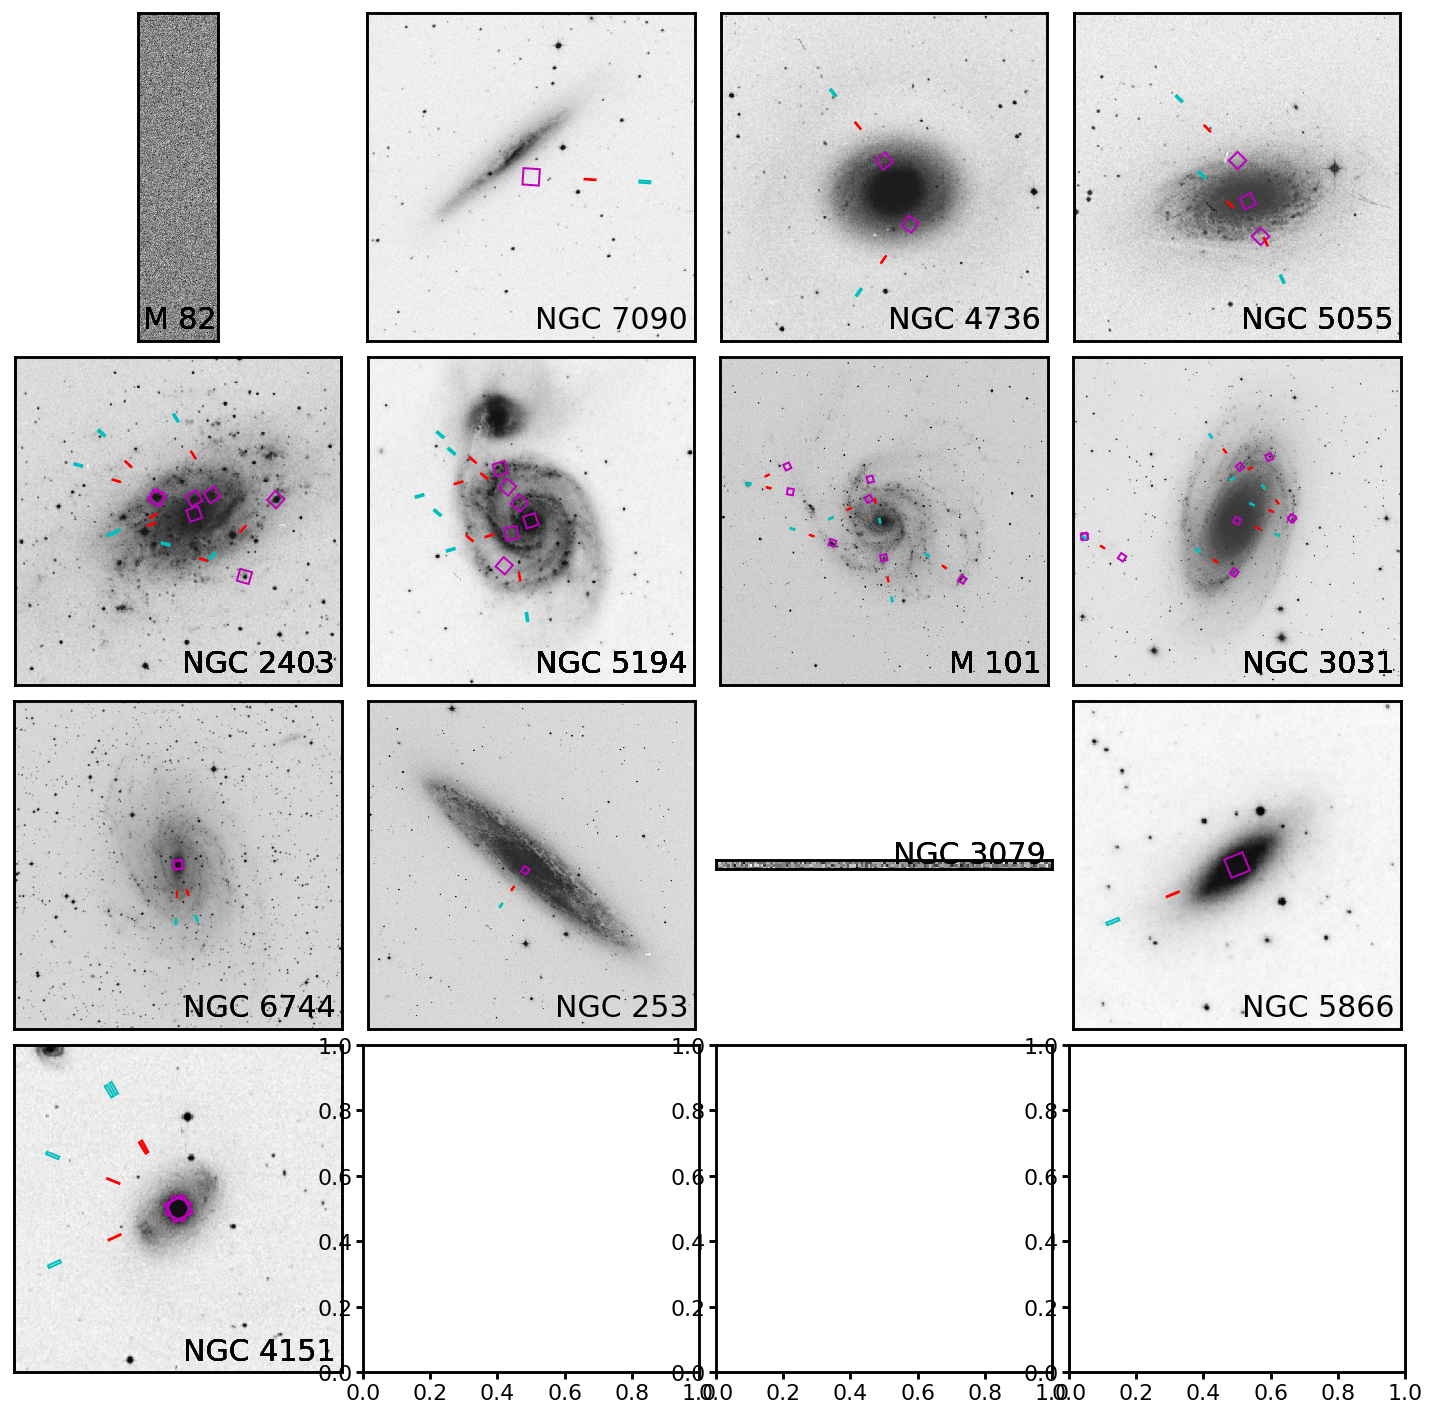

In [17]:
set_rcparams_prop(amp=1.15)

rr=1
aa=6
wrs=np.array([1.8, 0.2, 1.2, 0.05])
hrs=np.array([1])
fig = plt.figure(figsize=(20, 30))
fig = plt.figure(figsize=(25, 25))
ncol=4
nrow=4
gs1 = gridspec.GridSpec(nrow, ncol, figure=fig, 
#                         width_ratios=wrs, height_ratios=hrs,
                        hspace=0.05, wspace=0.05
                       )
pidxs=np.arange(ncol*nrow)
axs=[]
for i in range(len(pidxs)):
    ax=fig.add_subplot(gs1[i // ncol, i%ncol])
    axs.append(ax)


fidx=[0,0,0,0,0,
      0,0,1,0,0,
      0,0,0,0,0,
      0,0,0,0
     ]

cut_widths=np.array([
    350,300,400,400,
    400,400,1400,1600,
    600,1600,300,250,
    250,250,500,400,
])/3600*2


raoffs=np.array(
    [0,0,0,0,
     0.7,0,-0.4,0,
     0,0,0,0,
     0,0,0,0,
    ]
)

decoffs=np.array(
    [0.1,0,-0.05,-0.05,
     -0.1,0,0,0,
     0,0,0,0,
     0,0,-0.05,0,
    ]
)

minsep=0.5
file_sc=SkyCoord(fdf.ra, fdf.dec, frame='icrs', unit='deg')    
for i in range(len(objnames)):
# for i in range(8):
    ax=axs[i]
    objname=objnames[i]
    print(objname)
    sdf=df.loc[df['objname']==objname,:]
    sdf.index=np.arange(len(sdf))
    ra0, dec0=sdf.loc[0,'ra'], sdf.loc[0,'dec']
#     print(ra0, dec0)
    c = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    cond=np.array(file_sc.separation(c))<minsep
    match_df=fdf[cond]
    match_df.index=np.arange(np.sum(cond))
    # print(match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:])
    #fits_file=match_df.loc[fidx[i],'file_path']
    fits_file=match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:]
    print(fidx[i])
    hdu=fits.open(os.path.normpath(fits_file))
    hdr=hdu[0].header
    oiwcs=astropy.wcs.WCS(header=hdr) 
#     print(fits_file)
    
    cmap=cm.gray_r
    origin='lower'

    oim=hdu[0].data

    ra0, dec0=sdf.loc[0,'ra']+cut_widths[i]*raoffs[i], sdf.loc[0,'dec']+cut_widths[i]*decoffs[i]
#     print(ra0, dec0)
    cc = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    
    img_cutout_obj=Cutout2D(oim, cc, 
                       u.Quantity(cut_widths[i], unit='deg'),
                       wcs=oiwcs,
                    mode='trim',
#                     mode='partial',
                   )
    im=img_cutout_obj.data
    iwcs=img_cutout_obj.wcs

    
    img=ax.matshow(im, 
               cmap=cmap, 
               origin=origin, interpolation='none', 
#                zorder=1,
#               alpha=alpha, zorder=zorder, aspect=aspect, 
#                norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
                  )
#     print(objname)
    print('npt',len(sdf))
    
    for j in range(len(sdf)):
        jra, jdec=sdf.loc[j,'ra'], sdf.loc[j,'dec']        
        c_obj=SkyCoord(jra, jdec, 
                                          unit='deg',
                                          frame='icrs')
        if sdf.loc[j,'aperture']=='MDRS':
            sep=u.Quantity(-90.18-118.07, unit='arcsec')
            c_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
            print('MDRS!!!')

        sep=u.Quantity(90.18+118.07, unit='arcsec')
        m_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
        sep=u.Quantity(-10.27+118.07, unit='arcsec')
        h_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
         
        objs=[c_obj, m_obj, h_obj]
        xws=[30,4,1.25]
        yws=[30,20,20]
        clrs=['m','c','r']
        
        for k in range(3):
            pcent_x, pcent_y=iwcs.world_to_pixel(objs[k])
            psm=iwcs.pixel_scale_matrix
            pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
    #         print('pscale',pscale)
            pxwidth=xws[k]/3600/pscale
            pywidth=yws[k]/3600/pscale
#             edgecolor='m'
            edgecolor=clrs[k]
    #         edgecolor='k'
            sqlw=2


            rot_ang=0
            rot_ang=sdf.loc[j,'pa']
            recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
            rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
                                             angle=rot_ang,
                                             zorder=20,
        #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
        #                                      angle=(-180),
        #                                   facecolor='w', fill=True)
                                    linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
            #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
            art=ax.add_artist(rec)
        ax.text(0.98,0.02,objname,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes,
                size=30
               )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
#         pcent_x, pcent_y=iwcs.world_to_pixel(m_obj)
#         psm=iwcs.pixel_scale_matrix
#         pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
# #         print('pscale',pscale)
#         pxwidth=4/3600/pscale
#         pywidth=20/3600/pscale
#         edgecolor='c'
# #         edgecolor='k'
#         sqlw=3

        
#         rot_ang=0
#         rot_ang=sdf.loc[j,'pa']
#         recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
#         rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
#                                          angle=rot_ang,
#                                          zorder=20,
#     #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
#     #                                      angle=(-180),
#     #                                   facecolor='w', fill=True)
#                                 linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
#         #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
#         art=ax.add_artist(rec)
    
csp=0.0
fig.subplots_adjust(wspace=csp, hspace=csp)

# aa=cc.separation(c)
# np.array(Angle(aa, unit=u.deg))<0.5
match_df
fname='adap_target_pointings2022.pdf'
fig.savefig(fname,dpi=256, bbox_inches='tight')

In [ ]:
fdf.ra


0     148.969690000
1     148.969690000
2     148.969690000
3     148.969690000
4     324.120250000
5     192.721090000
6     192.721090000
7     192.721090000
8     192.721090000
9     198.955540000
10    198.955540000
11    198.955540000
12    198.955540000
13    198.955540000
14    114.214170000
15    114.214170000
16    114.214170000
17    114.214170000
18    202.469630000
19    202.469630000
20    202.469630000
21    210.802270000
22    210.802270000
23    210.802270000
24    148.888220000
25    148.888220000
26    148.888220000
27    148.888220000
28    141.548040000
29    141.548040000
30    287.442080000
31    190.533380000
32    190.533380000
33    190.533380000
34    190.533380000
35    190.533380000
36     35.639220000
37     35.639220000
38     35.639220000
39     35.639220000
40     35.639220000
Name: ra, dtype: object

In [ ]:
['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [ ]:
# print(obs_table)
# np.sum(obs_table['obs_collection']=='FUSE')
obs_table
# products = Observations.get_product_list(obs_table[0])
# products
data_url=obs_table[0]['dataURL']
cdir='./galex_fits/'
fname='_'.join([objname,'galex','fuv'])+'.fits.gz'
print(data_url)
print(cdir+fname)
# urllib.request.urlretrieve(data_url, cdir+fname)

http://archive.stsci.edu/pub/vospectra/fuse2/c057020100000nvo4ttagfcal_vo.fits
./galex_fits/NGC 253_galex_fuv.fits.gz


In [ ]:
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str8,int64,str4,str11,str9,float64,float64,float64,float64,float64,str2,str1,float64,float64,str1,str53,float64,str3,str6,str4,str1,str1,int64,str1,str56,str83,str78,str6,bool,float64,str7,str6,str6,str6,float64
spectrum,2,FUSE,c0570201000,NGC4631-F,190.57500000000005,32.563333,52695.0706713,52695.51438938,16500.0,UV,--,90000000000.0,119000000000.0,--,Observations of O VI Emission in the Halo of NGC 4631,nan,FUV,Murphy,C057,--,--,--,--,CIRCLE ICRS 190.575 32.563333 0.00416666666667,http://archive.stsci.edu/browse/previews/fuse/c0570201/c057020100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/c057020100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,342900,569778,569778,133.79708312972465
spectrum,2,FUSE,c0570202000,NGC4631-F,190.57500000000005,32.563333,53087.42503472,53088.28412073,27762.0,UV,--,90000000000.0,119000000000.0,--,Observations of O VI Emission in the Halo of NGC 4631,nan,FUV,Murphy,C057,--,--,--,--,CIRCLE ICRS 190.575 32.563333 0.00416666666667,http://archive.stsci.edu/browse/previews/fuse/c0570202/c057020200000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/c057020200000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,342901,569779,569779,133.79708312972465
spectrum,2,FUSE,c0570301000,NGC4631-H,190.48333300000002,32.553333,52694.44685185,52694.96520463,22965.0,UV,--,90000000000.0,119000000000.0,--,Observations of O VI Emission in the Halo of NGC 4631,nan,FUV,Murphy,C057,--,--,--,--,CIRCLE ICRS 190.483333 32.553333 0.00416666666667,http://archive.stsci.edu/browse/previews/fuse/c0570301/c057030100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/c057030100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,342902,569780,569780,142.90955841033593
spectrum,2,FUSE,p1340101000,NGC4631-A,190.53666666699996,32.5766666667,51663.00063657,51663.56815421,21535.0,UV,--,90000000000.0,119000000000.0,--,A Search for OVI Emission in the Halo of NGC 4631,nan,FUV,Murphy,P134,--,--,--,--,CIRCLE ICRS 190.536666667 32.5766666667 0.00416666666667,http://archive.stsci.edu/browse/previews/fuse/p1340101/p134010100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/p134010100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,345628,572506,572506,111.997938955208
spectrum,2,FUSE,p1340201000,NGC4631-B,190.53666666699996,32.56,51664.44222222,51664.81761068,16218.0,UV,--,90000000000.0,119000000000.0,--,A Search for OVI Emission in the Halo of NGC 4631,nan,FUV,Murphy,P134,--,--,--,--,CIRCLE ICRS 190.536666667 32.56 0.00416666666667,http://archive.stsci.edu/browse/previews/fuse/p1340201/p134020100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/p134020100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,345629,572507,572507,52.36125278343235
spectrum,2,FUSE,c0570101000,NGC4631-A,190.53666699999997,32.576667,52422.32480324,52422.4911716,7153.0,UV,--,90.0,119.0,--,--,nan,FUV,--,--,--,--,--,--,Circle J2000 190.536667 32.576667 0.00416666666667,http://archive.stsci.edu/missions/fuse/previews/c0570101/c057010100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/c057010100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,347253,574131,574131,111.99923464644657
spectrum,2,FUSE,c0570401000,NGC4631-I,190.54166699999996,32.551667,52421.42298611,52421.65853036,9407.0,UV,--,90.0,119.0,--,--,nan,FUV,--,--,--,--,--,--,Circle J2000 190.541667 32.551667 0.00416666666667,http://archive.stsci.edu/missions/fuse/previews/c0570401/c057040100000specttagf.gif,http://archive.stsci.edu/pub/vospectra/fuse2/c057040100000nvo4ttagfcal_vo.fits,PUBLIC,--,5885.0,science,347254,574132,574132,29.47758248623915


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from matplotlib import ticker
# import dotifs_util as util
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoLocator, FixedLocator,
                               AutoMinorLocator)
# import util
from scipy.optimize import curve_fit


import numpy as np
from scipy import constants
from scipy.interpolate import interp1d
import time
from os import path, getcwd
#from os import getcwd
import inspect
from math import pi
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.signal import convolve as scipyconvolve
import glob
stof=2*(2*np.log(2))**0.5

from astropy.io import fits

import math
import healpy as hp
import pylab

from astropy import units as u
from astropy.coordinates import SkyCoord


# from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

import csv
import numpy as np
import extinction
import requests
import pandas as pd
from PIL import Image, ImageDraw, ImageFilter
#import time
import os
from astroquery.simbad import Simbad
from astropy import units as u

import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'healpy'

In [ ]:
def set_rcparams_prop(amp=1, fs=22):
#     fs=18
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*amp
    tmns=tmjs/3.5*2*amp
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [ ]:
# df_sim = Simbad.query_object(galaxies['Object Name'][i])
df_sim = Simbad.query_object('NGC 4631')

In [ ]:
df_sim.columns
# df_sim.loc['RA',:]
print(df_sim['RA'], df_sim['DEC'])
coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
# coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs')
coords

In [ ]:
gal_list=[
    "NGC 4631",
    "NGC 3003",
    "NGC 891",
    "NGC 5746",
    "NGC 1353",
    "NGC 253",
    "NGC 3692",
    "NGC 3044",
    "NGC 5775",
    "NGC 4666",
    "NGC 625",
    "NGC 7064",
    "NGC 1406",
    "NGC 1448",
    "NGC 660",
    "IC 5052",
    "M82",
    "NGC 7582",
]

In [ ]:
df_res=Simbad.query_objects(gal_list)
coords = SkyCoord(df_res['RA'], df_res['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
coords

gdf=pd.DataFrame({
    'name':df_res['MAIN_ID'],   
    'ra':coords.ra.degree,
    'dec':coords.dec.degree,
    'l':coords.galactic.l.degree,
    'b':coords.galactic.b.degree,
})
gdf



In [ ]:
def under_sample(arr):
    iarr=arr[[np.arange(len(arr)//4)*4]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+1]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+2]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+3]]
    return iarr/4

def under_sample(arr):
    val0=arr[[np.arange(len(arr)//4)*4]]
    val1=arr[[np.arange(len(arr)//4)*4+1]]
    val2=arr[[np.arange(len(arr)//4)*4+2]]
    val3=arr[[np.arange(len(arr)//4)*4+3]]
    tval=val0+val1+val2+val3
    non0=(val0>0)*1+(val1>0)*1+(val2>0)*1+(val3>0)*1
    tval=tval/non0
    tval[non0==0]=0
    return tval


def mag2flam(mag, zero_pt=21.1, ABwave=None):
    if np.any(ABwave != None):
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [ ]:
lon_plot=np.radians(360-gdf['l'])
lat_plot=np.radians((gdf['b']))
lon_plot[lon_plot>np.pi]=lon_plot[lon_plot>np.pi]-2*np.pi

In [ ]:
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection="mollweide")

markersize=1

# rplon=np.radians(lon_plot)
# rplat=np.radians(lat_plot)
# rplon[rplon>np.pi]=rplon[rplon>np.pi]-2*np.pi

ax.scatter(lon_plot, lat_plot,
# ax.scatter(plon, plat,
#             -aspera_targets_ra.wrap_at(180 * u.deg).radian,
#             aspera_targets_dec.radian,
            marker="o",
            s=markersize*20,
            c="blue",
#             label='Aspera Science Targets'
            )

# odf=pd.DataFrame({
#     'gal_lon':plon,
#     'gal_lat':plat,}
# )
# print(len(odf))
# odf.to_csv('nox_target_coord_galactic.csv')

In [ ]:
gdf